# CMA/ES optimisation lapse rate, summed LL90 as metric, 3rd Try

This one is the last try with the summed LL90 as metric (before prodLL). Slightly different bounds for sigmax and lapse_rate.

Contains two tries.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [96]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [97]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import * 

In [88]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

## Reload data

In [6]:
%cd cmaes_bays09_ll90_try3_Mratiosigmaxlapserate_repetitions5_221115
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-e65a1559-7e76-4555-bdf6-feb9983a9c20.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_cmaes_11_2015/cmaes_bays09_ll90_try3_Mratiosigmaxlapserate_repetitions5_221115


In [7]:
%cd ../cmaes_bays09_ll90_try3_Mratiosigmaxlapserate_repetitions5_280316
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-361cfb0c-8010-4b14-83eb-4c64dab6ec60.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_cmaes_11_2015/cmaes_bays09_ll90_try3_Mratiosigmaxlapserate_repetitions5_280316


In [8]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [9]:
parameter_names_sorted

['ratio_conj', 'M', 'sigmax', 'lapse_rate']

In [10]:
df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)),
                             ('ratio_conj', candidates_parameters[:, 0]),
                             ('M', candidates_parameters[:, 1]),
                             ('sigmax', candidates_parameters[:, 2]),
                             ('lapse_rate', candidates_parameters[:, 3]),
                             ('dist_nll90', np.ma.masked_greater(fitness.flatten(), 1e8)),
                            ])

In [11]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits.dist_nll90 < LL_max_cutoff]

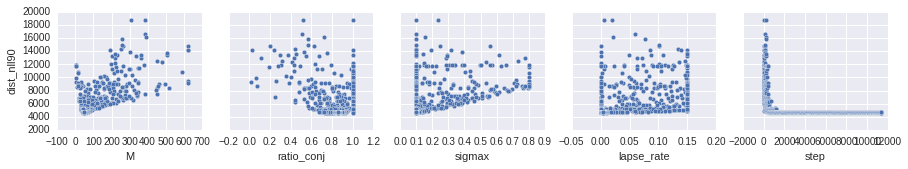

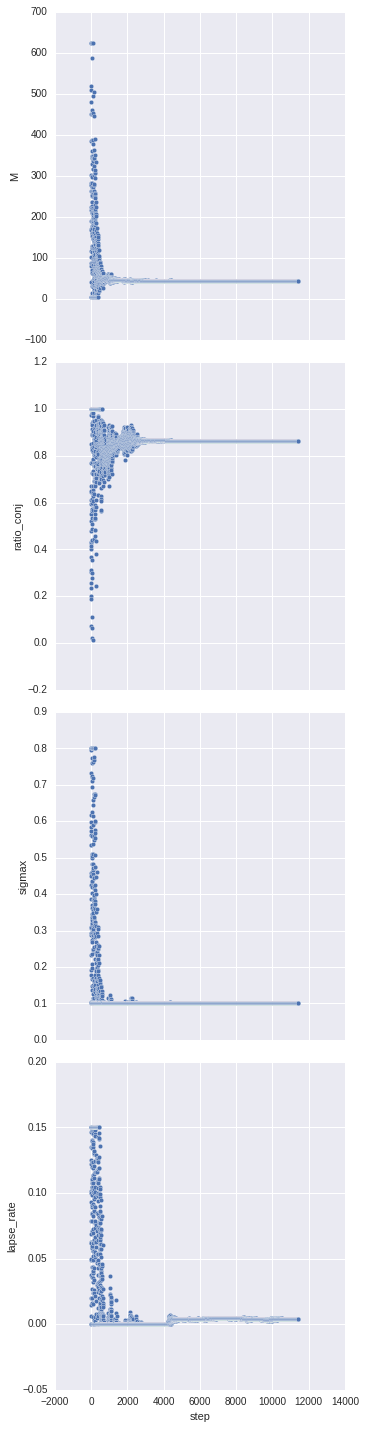

In [14]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'step'],
             y_vars=['dist_nll90']
            )

# Check learning
sns.pairplot(df_best_fits,
             y_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate'],
             x_vars=['step'],
             size=5
            )

## Plotly Scatter3D

In [15]:
df_best_fits.columns

Index([u'step', u'ratio_conj', u'M', u'sigmax', u'lapse_rate', u'dist_nll90'], dtype='object')

In [16]:
result_to_color = np.array(df_best_fits.dist_nll90)

col_min = np.min(result_to_color)
col_max = np.max(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = Scatter3d(
        x= df_best_fits.M,
        y= df_best_fits.ratio_conj,
        z= df_best_fits.sigmax,
        text= text,
        mode= 'markers',
        marker= Marker(
            color = result_to_color,
            size = 7,
            colorscale='Bluered',
            cmin=col_min,
            cmax=col_max,
            cauto=False
        )
    )
data = Data([trace1])
layout = Layout(
    title='Landscape for NLL90',
    scene=Scene(
        xaxis=XAxis(
            title='M',
        ),
        yaxis=YAxis(
            title='ratio_conj',
        ),
        zaxis=ZAxis(
            title='sigmax',
        )
    )
)
fig = Figure(data=data, layout=layout)
scatter3d_url = py.plot(fig)

In [17]:
dropdown_space = parameter_names_sorted
dropdown_default = 'lapse_rate'
metric_color_space = ['dist_nll90']
metric_color_default = 'dist_nll90'

g = GraphWidget(scatter3d_url)

class shifter:
    def __init__(self):
        self.slider_index = 0
        self.marker_size = 8
        self.filter_results = slice(None, None)
        self.metric_color = metric_color_default
        self.dropdown_value = dropdown_default
        
        self.change_color_source(metric_color_default)
        self.change_dropdown_value(dropdown_default)
    
    def change_dropdown_value(self, new_value):
        self.dropdown_value = new_value
        
        # Update the axes
        self.axes_parameters = dropdown_space[:]
        self.axes_parameters.remove(self.dropdown_value)
        
        # Update the grid of the dropdown parameter
        self.dropparam_gridified, self.dropparam_gridspace, self.dropparam_midspace = utils.gridify(df_best_fits[self.dropdown_value], bins=10)
        
        
    
    def change_color_source(self, new_value):
        self.metric_color = new_value
        self.result_to_color = np.array(df_best_fits[self.metric_color])
        self.result_to_color[self.result_to_color > 2*np.median(self.result_to_color)] = np.median(self.result_to_color)
        self.col_min = np.min(self.result_to_color)
        self.col_max = np.max(self.result_to_color)
    
    def on_color_source_change(self, name, old_value, new_value):
        self.change_color_source(new_value)
        self.replot()
    
    def on_dropdown_change(self, name, old_value, new_value):
        self.change_dropdown_value(new_value)
        p_slider.description='%s [all]' % self.dropdown_value
        self.replot()
    
    def on_slider_change(self, name, old_value, new_value):
        self.slider_index = new_value
        
        if self.slider_index > -1:
            self.filter_results = self.dropparam_gridified[self.slider_index]
            self.marker_size = 6
            p_slider.description='%s [%f]' % (self.dropdown_value, self.dropparam_gridspace[self.slider_index])
        else:
            self.filter_results = slice(None, None)
            self.marker_size = 6
            p_slider.description='%s [all]' % self.dropdown_value
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        self.replot()
        
    def replot(self):
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        new_trace = Scatter3d(
            x= df_best_fits[self.axes_parameters[0]][self.filter_results],
            y= df_best_fits[self.axes_parameters[1]][self.filter_results],
            z= df_best_fits[self.axes_parameters[2]][self.filter_results],
            text= self.text,
            mode= 'markers',
            marker= Marker(
                color = self.result_to_color[self.filter_results],
                size = self.marker_size,
                colorscale='Bluered',
                cmin=self.col_min,
                cmax=self.col_max,
                cauto=False
            )
        )
        g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None, })
        g.relayout({'title' : "Landscape for %s" % self.metric_color,
                    'scene.xaxis.title': self.axes_parameters[0],
                    'scene.yaxis.title': self.axes_parameters[1],
                    'scene.zaxis.title': self.axes_parameters[2],
                    })
        g.add_traces(new_trace)

p_state = shifter()
p_metric_drop = widgets.Dropdown(description='Metric for color', options=metric_color_space, value=metric_color_default)
p_variable_drop = widgets.Dropdown(description='Variable to slide', options=dropdown_space, value=dropdown_default)
p_slider = widgets.IntSlider(min=-1, max=p_state.dropparam_midspace.size-1, value=-1)
p_slider.description='%s [all]' % p_state.dropdown_value

p_slider.on_trait_change(p_state.on_slider_change, 'value')
p_variable_drop.on_trait_change(p_state.on_dropdown_change, 'value')
p_metric_drop.on_trait_change(p_state.on_color_source_change, 'value')

p_state.replot()

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:97: DeprecationWarning:

on_trait_change is deprecated: use observe instead

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:98: DeprecationWarning:

on_trait_change is deprecated: use observe instead

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:99: DeprecationWarning:

on_trait_change is deprecated: use observe instead



In [18]:
display(p_metric_drop)
display(p_variable_drop)
display(p_slider)
display(g)

## Check parameters values obtained

In [98]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).iloc[0]
df_bestparams

step          11399.000000
ratio_conj        0.862711
M                45.066868
sigmax            0.100199
lapse_rate        0.004101
dist_nll90     4668.153650
Name: 11399, dtype: float64

In [90]:
%env WORKDIR_DROP

'/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory'

In [99]:
%run /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/experimentlauncher.py \
--action_to_do launcher_do_fitexperiment_allmetrics --inference_method none  --num_samples 200  --renormalize_sigmax \
--autoset_parameters --code_type mixed  --sigmay 0.00001  --experiment_id bays09  \
--lapse_rate {df_bestparams['lapse_rate']} --M {int(df_bestparams['M'])} --sigmax {df_bestparams['sigmax']} \
--ratio_conj {df_bestparams['ratio_conj']} \
--filter_datapoints_size 1500 --filter_datapoints_selection 'random'

Arguments: ['--action_to_do', 'launcher_do_fitexperiment_allmetrics', '--inference_method', 'none', '--num_samples', '200', '--renormalize_sigmax', '--autoset_parameters', '--code_type', 'mixed', '--sigmay', '0.00001', '--experiment_id', 'bays09', '--lapse_rate', '0.00410114820671', '--M', '45', '--sigmax', '0.100198719718', '--ratio_conj', '0.862711102622', '--filter_datapoints_size', '1500', '--filter_datapoints_selection', 'random']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'action_to_do': 'launcher_do_fitexperiment_allmetrics', 'code_type': 'mixed', 'renormalize_sigmax': True, 'selection_n

In [100]:
print "!!!! Redo all plots from paper here directly... !!!"

!!!! Redo all plots from paper here directly... !!!


In [101]:
plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)

Doing Paper plots for bays09. 
Fig5 1, Fig6 1, Fig13 1


DATA T 1
DATA T 2
mu: 0.256, kappa: 0.031
{'R': 23.212476593828107, 'u': 0.8200073034089036, 'pvalue': 0.20610597185496826, 'V': 22.45682486980197}
DATA T 4
mu: 0.101, kappa: 0.093
{'R': 208.85727076768345, 'u': 4.3804581256799429, 'pvalue': 5.9215025343117844e-06, 'V': 207.78337308211098}
DATA T 6
mu: 0.055, kappa: 0.118
{'R': 442.59324887027765, 'u': 7.2164928910340009, 'pvalue': 2.666755705149626e-13, 'V': 441.91813288638764}


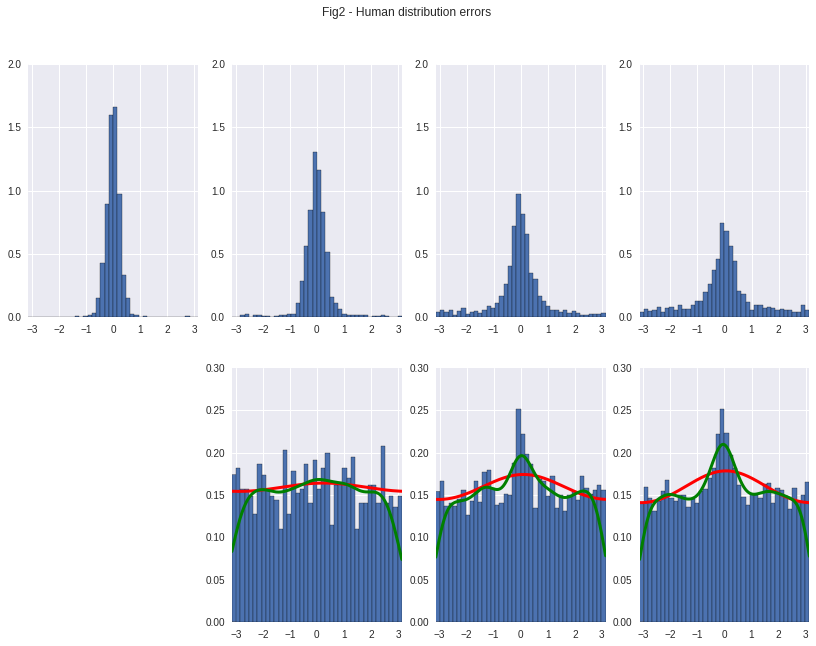

In [102]:
axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

MODEL T 1
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -490.72
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 30.06 10:40                                                     
Loglikelihood: 219.99
top 90% loglike: 484.69
MODEL T 2
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -1399.87
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 30.06 10:42                                                     
Loglikelihood: -484.27
top 90% loglike: -78.71
mu: 0.182, kappa: 0.133
{'R': 99.407751224249992, 'u': 3.5696112296322347, 'pvalue': 0.00017875569866143692, 'V': 97.757829599666422}
MODEL T 4
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -2350.45
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 30.06 10:44                                                     
Loglikelihood: -1223.35
top 90% loglike: -750.93
mu: 0.095, kappa: 0.212

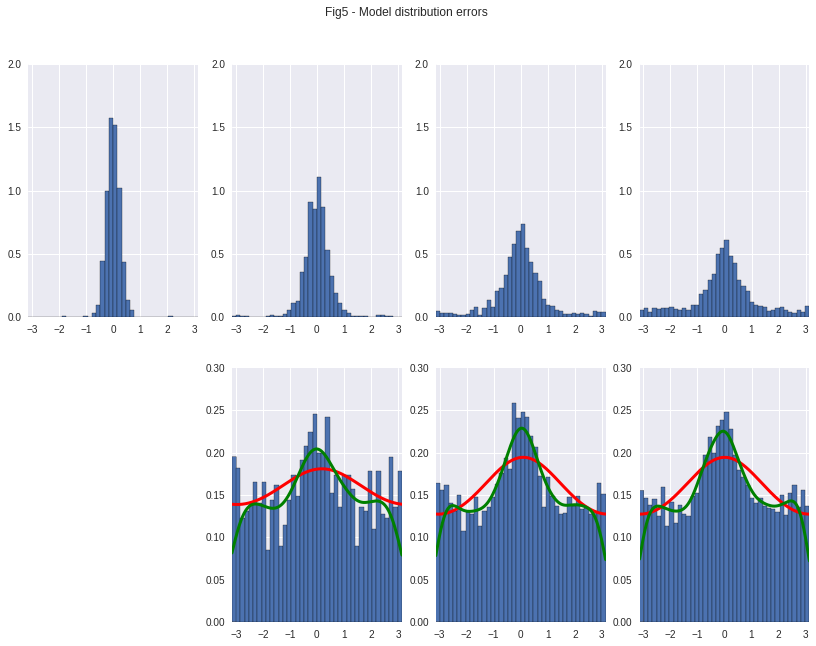

In [103]:
axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

0.00%, -- left - 30.06 10:45
Fit for T=1, 1/1
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: 219.99
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 30.06 10:45                                                     
Loglikelihood: 214.77
top 90% loglike: 485.97
25.00%, 9s left - 30.06 10:46
Fit for T=2, 1/1
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -484.27
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 30.06 10:45                                                     
Loglikelihood: -422.49
top 90% loglike: -61.59
50.00%, 6s left - 30.06 10:46
Fit for T=4, 1/1
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -1223.35
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 30.06 10:46                                                     
Loglikelihood: -1173.40
top 90% loglike: -702.76
75.00%, 3s left - 30.06 10:46
Fit for T=6, 1/1
Ru

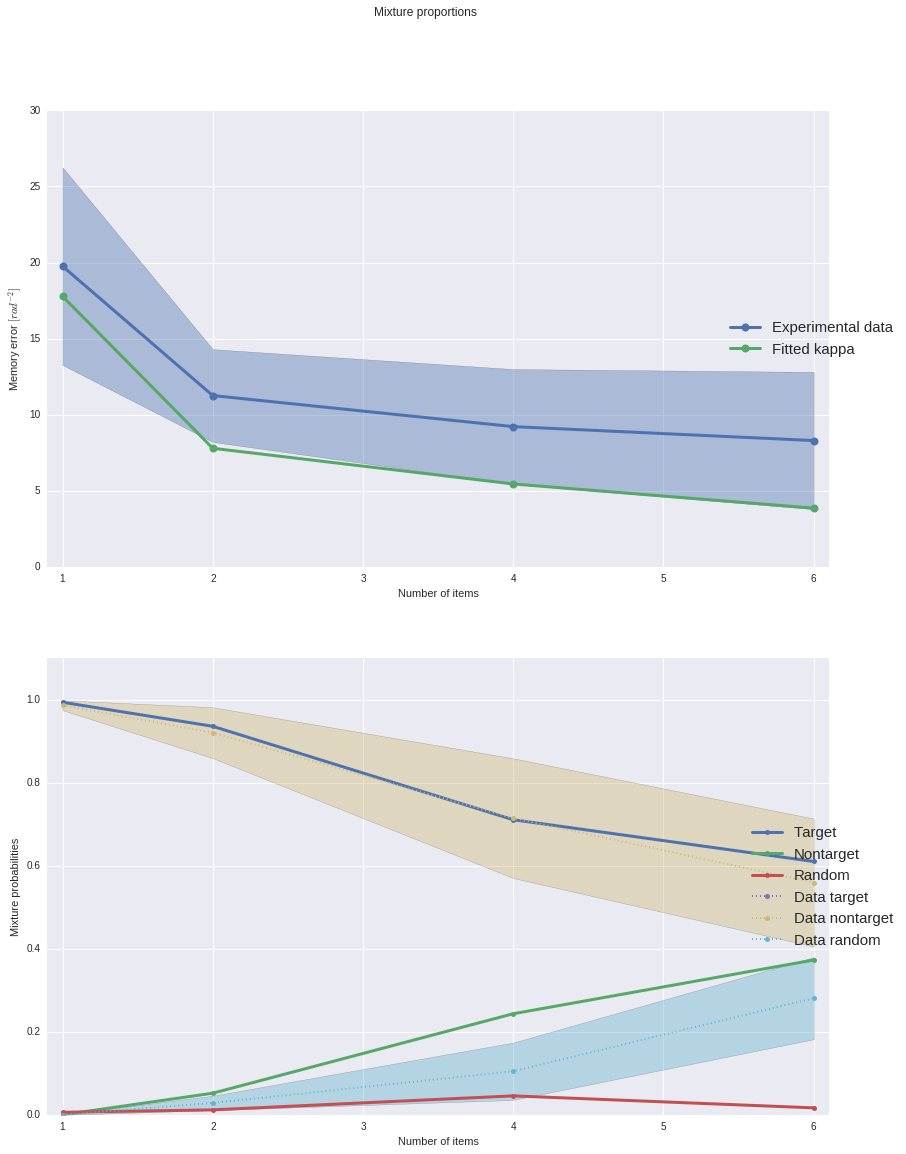

In [104]:
axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13()

### This run got really good? Need to restart to check.

This will be try4. Also means that the parameters bounds were really what mattered, and not the prodLL... 

oh well :/